In [478]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import torch
import torch.nn as nn
from torchvision.datasets import Cityscapes

In [457]:
root = os.getcwd()

In [488]:
# Torch dataset for cityscapes from here:
# github.com/pytorch/vision/blob/master/torchvision/datasets/cityscapes.py

train_dataset = Cityscapes(os.path.join(root, 'cityscapes'),
                          split='train',
                          mode='fine',
                          target_type=["instance", "semantic", "polygon", "color"])

In [514]:
img, (inst, smnt, poly, color) = train_dataset[1]

SyntaxError: invalid syntax (<ipython-input-514-ecdc51f57ed9>, line 1)

In [516]:
for i, obj in enumerate(poly['objects']):
    print('{}: {}'.format(i, obj['label']))

0: sky
1: road
2: vegetation
3: sidewalk
4: building
5: sidewalk
6: terrain
7: wall
8: pole
9: pole
10: static
11: pole
12: static
13: pole
14: car
15: car
16: pole
17: static
18: car
19: static
20: pole
21: wall
22: bicycle
23: vegetation
24: building
25: static
26: terrain
27: wall
28: fence
29: fence
30: static
31: person
32: person
33: pole
34: pole
35: static
36: dynamic
37: static
38: pole
39: rider
40: bicycle
41: bicycle
42: ego vehicle
43: out of roi


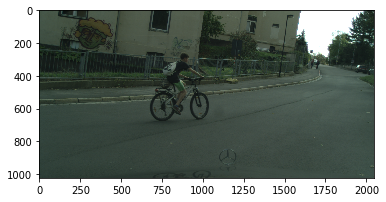

In [517]:
plt.imshow(img)

In [519]:
left_image = plt.imread(os.path.join(root, 
                                     'KITTI', 
                                     'training', 
                                     'image_2', 
                                     '000001_11.png'))
right_image = plt.imread(os.path.join(root,
                                      'KITTI', 
                                      'training', 
                                      'image_3', 
                                      '000001_11.png'))

In [520]:
l_min = left_image.min()
l_max = left_image.max()
left_image = ((left_image - l_min)*(255/(l_max-l_min))).astype(np.uint8)
r_min = right_image.min()
r_max = right_image.max()
right_image = ((right_image - r_min)*(255/(r_max-r_min))).astype(np.uint8)

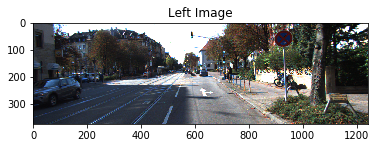

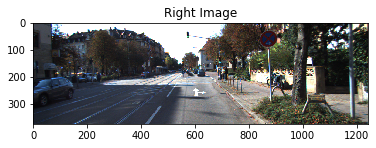

In [521]:
plt.imshow(left_image)
plt.title('Left Image')
plt.show()
plt.imshow(right_image)
plt.title('Right Image')
plt.show()

In [526]:
def add_fog(L, R, tFactor, atmLight):
    """Adds synthetic fog to an image"""
    
    foggy = np.copy(L)
    
    # Convert RBG images to gray prior to SGM
    L_gray = cv.cvtColor(L, cv.COLOR_BGR2GRAY)
    R_gray = cv.cvtColor(R, cv.COLOR_BGR2GRAY)
    
    # Calculate disparity map using semi-global matching
    stereo = cv.StereoSGBM_create(numDisparities=96, blockSize=15)
    disparity = stereo.compute(L_gray, R_gray)
    
    # Shift values to minimum of 0
    disparity = disparity - disparity.min() + 1
    
    # Calculate depth using cityscapes camera parameters
    depth = ((0.22 * 2262) / disparity).astype(np.uint8)
    print(depth.max())
    
     # Smoothen depth image
    depth = cv.medianBlur(depth, 15)
    
    # Convert disparity image to range 0-255
    min = disparity.min()
    max = disparity.max()
    disparity = ((disparity - min)*(255/(max-min))).astype(np.uint8)
    
    plt.imshow(disparity)
    plt.title('Depth Map')
    plt.show()
    
    # Add fog
    n, m = foggy.shape[0:2]
    for i in range(n):
        for j in range(m):
            # Compute transmission
            t = np.exp(-tFactor/depth[i, j])
          
            # Set intensity of fog
            foggy[i, j, :] = t*foggy[i, j, :] + (1-t)*atmLight
        
    # Return foggy image
    return foggy        

241


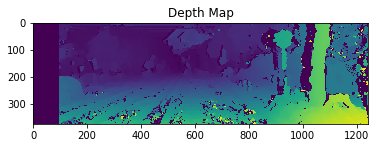

/home/danielzgsilva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


In [527]:
foggy = add_fog(left_image, right_image, 2, 1)

In [468]:
np.array_equal(left_image, foggy)

False

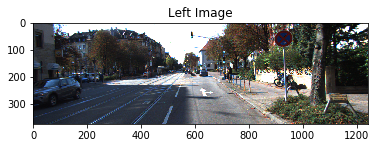

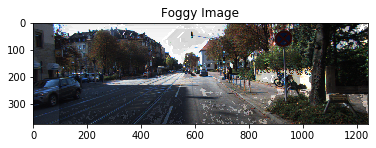

In [469]:
plt.imshow(left_image)
plt.title('Left Image')
plt.show()
plt.imshow(foggy)
plt.title('Foggy Image')
plt.show()

In [435]:
def PSNR(orig, synthetic):
    rmse = np.sqrt(np.sum(np.average((orig-synthetic)**2)))
    
    psnr = 20 * np.log10(orig.max()/rmse)
    
    return psnr

In [436]:
PSNR(left_image, foggy)

/home/danielzgsilva/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


inf

In [437]:
np.array_equal(orig, left_image)

True